In [3]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from utils.basic_utils import csv_store, csv_ext, numeric_cols
from utils.pricing import dummy_col
from utils.pricing import rename_col
from utils.fundamental import chain_outlier
from utils.TechnicalDS import TechnicalDS

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

Loading utils/config.json


Using TensorFlow backend.


In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Context data

In [6]:
# context
context = {
    'ml_path': '../ML/',
    'model_name': 'micro_TF.h5',
    'tmp_path': '../tmp/',
    'px_vol_ds': 'universe-px-vol-ds.h5',
    'trained_cols': 'micro_TF_train_cols.npy',
    'look_ahead': 120,
    'look_back': 252*3,
    'load_ds': True,
    'scale': True,
    'test_size': .05,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
    'units': 300, #850
    'max_iter': 10, #50
    'l2_reg': 0.01,
}

In [7]:
# get latest pricing file from inferece server
# px_close_ds = context['px_vol_ds']
# tmp_path = context['tmp_path']
# os.makedirs(tmp_path, exist_ok=True)
# !scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

In [8]:
tech_ds = TechnicalDS(
    context['tmp_path'], 
    context['px_vol_ds'], 
    load_ds=True, 
    look_ahead=context['look_ahead'], 
    max_draw_on=True)
y_col = tech_ds.ycol_name

Target date: 2019-05-23
Loading file quote/csv/2019-05-23
Loading file summary-categories/assetProfile
251 companies above 3.1x in the last 7.0 years
Sectors: 11, Industries: 136


### Final

In [9]:
def pre_process_ds(context):
    raw_df = tech_ds.stitch_companies_groups()
    print(f'Shape excluding NAs: {raw_df.shape}')
    symbols = raw_df.reset_index().set_index(['symbol']).index
    sector_map = tech_ds.profile.loc[tech_ds.tickers,'sector'].to_dict()
    raw_df.loc[:, 'sector'] = symbols.map(sector_map)
    raw_df = chain_outlier(raw_df, None)
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(raw_df)
    if scale_on: raw_df.loc[:, num_cols] = scaler.fit_transform(
        raw_df[num_cols])
    # add categoricals
    raw_df.dropna(subset=['sector'], inplace=True)
    raw_df = dummy_col(raw_df, 'sector', shorten=True)
    return raw_df

In [11]:
def get_train_test_sets(context):
    
    test_size = context['test_size']
    joined_df = pre_process_ds(context)
    cut_range = tech_ds.return_intervals(tresholds=[0.6, 0.8])
    TechnicalDS.labelize_ycol(
        joined_df, tech_ds.ycol_name,
        cut_range, tech_ds.forward_return_labels)
    
    joined_df.dropna(inplace=True)
    days = len(joined_df.index.levels[0].unique())
    print(f'Training for {days} dates, {round(days/252, 1)} years')

    train_df = joined_df.reset_index(drop=True) # drop date
    print(f'Pre X, y columns: {train_df.columns}')

    # create training and test sets
    X, y = train_df.drop(columns=y_col), train_df[y_col]
    sss = StratifiedShuffleSplit(
        n_splits=1, test_size=test_size, random_state=42)
    # just one split
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        break

    return X_train, X_test, y_train, y_test

In [12]:
def train_ds(context):
    
    max_iter = context['max_iter']
    l2_reg = context['l2_reg']
    units = context['units']
    trained_cols = context['trained_cols']
    X_train, X_test, y_train, y_test = get_train_test_sets(context)
    y_train_oh = pd.get_dummies(y_train)[tech_ds.forward_return_labels]
    y_test_oh = pd.get_dummies(y_test)[tech_ds.forward_return_labels]

    # Keras Model
    model = Sequential()
    model.add(Dense(units, input_dim=X_train.shape[1], use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(units, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(units, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(int(units/2), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(len(pd.unique(y_train)), activation='softmax'))
    keras.regularizers.l2(l2_reg)

    opt = Adam()

    ml_path, model_name = context['ml_path'], context['model_name']
    fname = ml_path + model_name

    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
    checkpointer = ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)
    csv_logger = CSVLogger('micro-train.log')

    # save training columns, feature order
    np.save(ml_path + trained_cols, X_train.columns)
    print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
    print('Saved: ', ml_path + trained_cols)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt, metrics=['accuracy'])
    history = model.fit(
        X_train, y_train_oh, validation_data=(X_test, y_test_oh),
        epochs=max_iter, batch_size=64,
        callbacks=[es, checkpointer, csv_logger])

    score = model.evaluate(X_test, y_test_oh)
    print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

In [13]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']

    joined_df = pre_process_ds(context)
    joined_df.reset_index(level=1, inplace=True)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    # save feature order
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True)
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        for c in missing_cols:
            pred_X[c] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])

    labels = tech_ds.forward_return_labels
    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: labels[x], preds_classes))
    probs = np.round(preds, 3)
    # higest prob
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs]
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=labels)
    pred_df = pd.concat([pred_df, prob_df[labels]], axis=1)
    pred_df.index.name = 'pred_date'

    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(tech_ds.tgt_date))

    return pred_df

#### Train

In [ ]:
%time train_ds(context)

#### Predict

In [25]:
%%time 
# predict for all
pred_df = predict_ds(context)

OCLHV dataframes
Inverting instruments
Change dataframes
Relative performance dataframes
Relative volume and dollar value dataframes
Realized volatility dataframe
Percentage change stds dataframes
Ranked returns dataframes
Max draw/pull dataframes
Forward return dataframe
Group index
Group percentage changes
Group pct stds
Group performance deltas
% above MA by group
% positive / negative chg stds by group
Group 50 day stds
Group 50 day deltas
Creating group dictionary
Dataset columns: Index(['PctChg1', 'PctChg20', 'PctChg50', 'PctChg200', 'PctChgStds1',
       'PctChgStds20', 'PctChgStds50', 'PctChgStds200', 'IntraDayChg',
       'OpenGap', 'Pct50MA', 'Pct200MA', 'Pct52WH', 'Pct52WL', 'PctVol10DA',
       'PctVol50DA', 'PctDV10DA', 'PctDV50DA', 'RollRealVol30', 'MaxDraw120',
       'MaxPull120', 'fwdRet120', 'PerfRank20', 'PerfRank50', 'PerfRank200',
       'pctGt50MAAll', 'pctGt50MASect', 'pctGt50MAInd', 'pctGt200MAAll',
       'pctGt200MASect', 'pctGt200MAInd', 'pctPosStdsAll', 'pct

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


pred_X.shape (184464, 61)
pred_X.shape (184464, 60)
Loaded ../ML/micro_TF.h5
Saved recommend/micro_ML/2019-05-22.csv
CPU times: user 6min 21s, sys: 7min 30s, total: 13min 51s
Wall time: 2min 51s


#### Store / Read S3

In [26]:
s3_path = context['s3_path']

In [27]:
# read from S3
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{tech_ds.tgt_date}'), 
    index_col='pred_date', parse_dates=True)

#### Visualize

In [28]:
tech_ds.tickers[:5]

['NFLX', 'BEAT', 'TAL', 'VIPS', 'AAXN']

In [29]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

Prediction distribution


bear      0.40
bull      0.40
neutral   0.13
long      0.05
short     0.02
Name: pred_label, dtype: float64

In [1]:
def plot_symbol_hist_pred(pred_symbol, clean_co_px, context, pred_df, labels):
    
    # pred_symbol = random.choice(joined_df.symbol.unique())
    pred_symbol = pred_symbol if pred_symbol is not None else random.choice(joined_df.symbol.unique())
    px_df = clean_co_px[pred_symbol]
    px_df.name = 'close'
    look_ahead = context['look_ahead']
    pct_chg_df = px_fwd_ret(px_df, look_ahead, int(look_ahead/4))
    pct_chg_df.name = 'pct_chg'

    co_pred = pred_df.loc[pred_df.symbol.isin([pred_symbol]), ['pred_class'] + labels]
    hist_pred = pd.concat([px_df.loc[pred_df.index.unique()], co_pred['pred_class']], axis=1, sort=False)

    # forward looking returns
    pct_chg_df.loc[pred_df.index.unique()].dropna().plot(
        title=f'{pred_symbol} {int(np.mean(context["look_ahead"]))} day forward looking return', 
        figsize=(15, 2), grid=True, secondary_y='pct_chg')

    # historical predictions
    hist_pred.dropna().plot(
        title=f'{pred_symbol} historical prediction', 
        figsize=(15, 5), secondary_y='pred_class')

    # probability distribution
    co_pred[labels].plot.area(
        title='Prediction probabilities', 
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0)

symbol = 'ADBE'
plot_symbol_hist_pred(
    symbol, tech_ds.clean_px, context, 
    pred_df, tech_ds.forward_return_labels)

NameError: name 'tech_ds' is not defined

In [190]:
pred_df.loc[pred_df.symbol.isin([symbol])].head()

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2016-05-18,TAL,4,bull,0.88,0.00,0.00,0.04,0.08,0.88
2016-05-19,TAL,4,bull,0.89,0.00,0.00,0.02,0.09,0.89
2016-05-20,TAL,4,bull,0.93,0.00,0.00,0.02,0.05,0.93
2016-05-23,TAL,4,bull,0.83,0.00,0.00,0.01,0.16,0.83
2016-05-24,TAL,4,bull,0.86,0.00,0.00,0.01,0.14,0.86


### Other experiments

#### Visualize forward looking returns

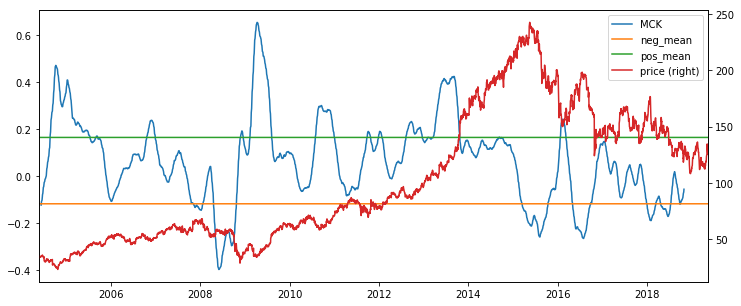

In [103]:
"""
An approach to forward looking returns, 
is it one period, an average of multiple periods, more recent, less recent?
"""
look_ahead = 120; smooth = int(look_ahead/4); s = 'MCK'
df = pd.DataFrame(px_fwd_ret(clean_co_px[s], look_ahead, smooth))
df['neg_mean'] = df[s].loc[df[s]<0].mean()
df['pos_mean'] = df[s].loc[df[s]>0].mean()
df['price'] = clean_co_px[s]
df.plot(figsize=(12,5), secondary_y='price')

In [12]:
# try with full universe
look_ahead = context['look_ahead']
Y = clean_co_px.apply(px_fwd_ret, args=(look_ahead, int(look_ahead/4)))
Y = Y[~(Y.isna().all(1))]

In [ ]:
Y.describe().T.sort_values(by='max')

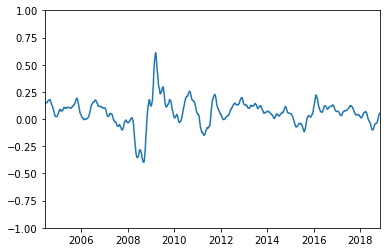

In [15]:
Y.iloc[:, :].dropna(axis=1).mean(axis=1).plot(ylim=(-1, 1), legend=False)

#### Train universe on long-term winners

In [282]:
hist_return = best_performers(clean_co_px, tickers, years=10, quantile=0.75)
print(f'{len(hist_return.index)} companies')
desc_df = pd.concat([
    profile.loc[hist_return.index, ['sector', 'industry', 'country',]],
    quotes.loc[hist_return.index, ['shortName', 'marketCap']]], axis=1)
desc_df.loc[:, 'marketCap'] = desc_df.marketCap / 10**9
desc_df.loc[:, 'size'] = discret_rets(desc_df.marketCap, mkt_cap_cuts, mkt_cap_labels)

hist_return = pd.concat([hist_return, desc_df], axis=1, sort=False)

236 companies


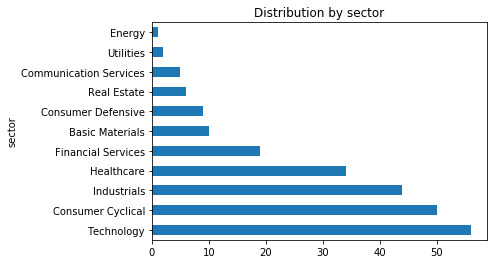

industry
Software - Application            15
Business Services                 10
Semiconductors                     9
Diversified Industrials            9
Medical Instruments & Supplies     8
Diagnostics & Research             8
Internet Content & Information     7
Health Care Plans                  7
Biotechnology                      6
Airlines                           6
Name: sector, dtype: int64

In [283]:
by_sect = desc_df.groupby(by=['sector']).count().iloc[:,0].sort_values(ascending=False)
by_sect.plot.barh(title='Distribution by sector');
plt.show()

by_ind = desc_df.groupby(by=['industry']).count().iloc[:,0].sort_values(ascending=False)
by_ind.head(10)

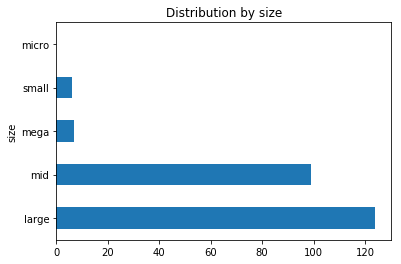

In [284]:
desc_df.groupby(by=['size']).count().iloc[:,0].sort_values(ascending=False).plot.barh(title='Distribution by size');

In [293]:
group_winners = hist_return.groupby(by=['sector']).agg(['count', 'mean'])
group_winners[['totalReturn', 'marketCap']]\
    .sort_values(by=('totalReturn','mean'), ascending=False)\
    .dropna()

totalReturn       marketCap       
                             count  mean     count   mean
sector                                                   
Technology                      56 16.06        56 145.70
Consumer Cyclical               50 10.81        50  50.10
Communication Services           5 10.44         5  63.25
Healthcare                      34  9.22        34  29.54
Industrials                     44  8.51        44  25.06
Basic Materials                 10  8.44        10   6.81
Consumer Defensive               9  8.22         9  25.25
Financial Services              19  7.75        19  49.33
Real Estate                      6  7.53         6  22.73
Utilities                        2  5.47         2  15.39
Energy                           1  5.14         1  25.98

In [316]:
group_winners = hist_return.groupby(by=['sector', 'industry', 'shortName']).agg(['count', 'mean'])
group_winners[['totalReturn', 'marketCap']]\
    .sort_values(by=('totalReturn','mean'), ascending=False)\
    .dropna().head(20)

totalReturn  \
                                                                                                 count   
sector                 industry                            shortName                                     
Technology             Software - Infrastructure           CyberArk Software Ltd.                    1   
Consumer Cyclical      Media - Diversified                 Netflix, Inc.                             1   
                       Specialty Retail                    Ulta Beauty, Inc.                         1   
                       Restaurants                         Domino's Pizza Inc                        1   
Healthcare             Diagnostics & Research              DexCom, Inc.                              1   
Consumer Cyclical      Apparel Stores                      lululemon athletica inc.                  1   
Healthcare             Medical Devices                     Align Technology, Inc.                    1   
Financial Services     Capital Markets                     MarketAxess Holdings, Inc.                1   
Healthcare             Biotechnology                       Incyte Corporation                        1   
Communication Services Telecom Services                    Vonage Holdings Corp.                     1   
Industrials            Rental & Leasing Services           United Rentals, Inc.                      1   
Consumer Cyclical      Specialty Retail                    Amazon.com, Inc.                          1   
Technology             Internet Content & Information      TENCENT                                   1   
Consumer Cyclical      Specialty Retail                    MercadoLibre, Inc.                        1   
Basic Materials        Building Materials                  Trex Company, Inc.                        1   
Technology             Semiconductor Equipment & Materials Universal Display Corporation             1   
                       Semiconductors                      NVIDIA Corporation                        1   
                       Software - Infrastructure           Fair Isaac Corproation                    1   
Consumer Cyclical      Leisure                             Booking Holdings Inc. Common St           1   
Consumer Defensive     Beverages - Wineries & Distilleries Constellation Brands, Inc.                1   

                                                                                                   \
                                                                                             mean   
sector                 industry                            shortName                                
Technology             Software - Infrastructure           CyberArk Software Ltd.          428.37   
Consumer Cyclical      Media - Diversified                 Netflix, Inc.                    64.90   
                       Specialty Retail                    Ulta Beauty, Inc.                39.96   
                       Restaurants                         Domino's Pizza Inc               33.55   
Healthcare             Diagnostics & Research              DexCom, Inc.                     30.73   
Consumer Cyclical      Apparel Stores                      lululemon athletica inc.         28.37   
Healthcare             Medical Devices                     Align Technology, Inc.           27.80   
Financial Services     Capital Markets                     MarketAxess Holdings, Inc.       26.88   
Healthcare             Biotechnology                       Incyte Corporation               26.77   
Communication Services Telecom Services                    Vonage Holdings Corp.            24.60   
Industrials            Rental & Leasing Services           United Rentals, Inc.             24.22   
Consumer Cyclical      Specialty Retail                    Amazon.com, Inc.                 24.19   
Technology             Internet Content & Information      TENCENT                          23.44   
Consumer Cyclical      Specialty Ret

In [324]:
group_winners = hist_return.groupby(by=['sector', 'industry']).agg(['count', 'mean'])
group_winners[['totalReturn', 'marketCap']]\
    .sort_values(by=('totalReturn','mean'), ascending=False)\
    .dropna().head(20)

totalReturn         \
                                                                 count   mean   
sector                 industry                                                 
Technology             Software - Infrastructure                     3 150.42   
Healthcare             Medical Devices                               1  27.80   
Consumer Cyclical      Media - Diversified                           5  18.97   
                       Specialty Retail                              6  18.77   
Industrials            Rental & Leasing Services                     2  16.96   
Consumer Defensive     Beverages - Wineries & Distilleries           1  16.59   
Consumer Cyclical      Apparel Stores                                3  15.02   
Healthcare             Long-Term Care Facilities                     1  14.67   
Industrials            Staffing & Outsourcing Services               3  13.25   
Consumer Cyclical      Restaurants                                   5  12.64   
Technology             Electronic Gaming & Multimedia                1  12.07   
Financial Services     Capital Markets                               4  11.98   
Consumer Cyclical      Auto Parts                                    2  11.92   
Communication Services Telecom Services                              4  11.84   
Consumer Defensive     Beverages - Brewers                           1  11.50   
Technology             Semiconductor Equipment & Materials           4  11.44   
Real Estate            REIT - Industrial                             2  11.25   
Industrials            Aerospace & Defense                           5  11.12   
Consumer Cyclical      Leisure                                       4  10.81   
Basic Materials        Building Materials                            3  10.72   

                                                           marketCap         
                                                               count   mean  
sector                 industry                                              
Technology             Software - Infrastructure                   3 331.54  
Healthcare             Medical Devices                             1  25.81  
Consumer Cyclical      Media - Diversified                         5  87.17  
                       Specialty Retail                            6 172.15  
Industrials            Rental & Leasing Services                   2   6.16  
Consumer Defensive     Beverages - Wineries & Distilleries         1  38.92  
Consumer Cyclical      Apparel Stores                              3  40.89  
Healthcare             Long-Term Care Facilities                   1   3.00  
Industrials            Staffing & Outsourcing Services             3   4.03  
Consumer Cyclical      Restaurants                                 5  26.98  
Technology             Electronic Gaming & Multimedia              1  11.28  
Financial Services     Capital Markets                             4  29.43  
Consumer Cyclical      Auto Parts                                  2   2.51  
Communication Services Telecom Services                            4  29.66  
Consumer Defensive     Beverages - Brewers                         1   3.94  
Technology             Semiconductor Equipment & Materials         4   6.32  
Real Estate            REIT - Industrial                           2   9.34  
Industrials            Aerospace & Defense                         5  56.60  
Consumer Cyclical      Leisure                                     4  28.75  
Basic Materials        Building Materials                          3   2.93

In [322]:
hist_return.loc[hist_return.industry.isin(['Software - Application']), :]\
    .sort_values(by='totalReturn', ascending=False)

,totalReturn,sector,industry,country,shortName,marketCap,size
MANH,15.22,Technology,Software - Application,United States,"Manhattan Associates, Inc.",4.24,mid
CRM,14.85,Technology,Software - Application,United States,Salesforce.com Inc,119.76,large
TYL,12.68,Technology,Software - Application,United States,"Tyler Technologies, Inc.",8.19,mid
CDNS,12.25,Technology,Software - Application,United States,"Cadence Design Systems, Inc.",19.30,large
ADBE,10.12,Technology,Software - Application,United States,Adobe Inc.,136.55,large
RHT,9.53,Technology,Software - Application,United States,"Red Hat, Inc.",32.98,large
INTU,9.18,Technology,Software - Application,United States,Intuit Inc.,63.59,large
ADSK,8.42,Technology,Software - Application,United States,"Autodesk, Inc.",38.38,large
PTC,7.33,Technology,Software - Application,United States,PTC Inc.,9.99,mid
ANSS,6.20,Technology,Software - Application,United States,"ANSYS, Inc.",15.74,large


#### historical price performance analysis

Mean positive: 0.23362956941127777, Mean negative: -0.13078920543193817


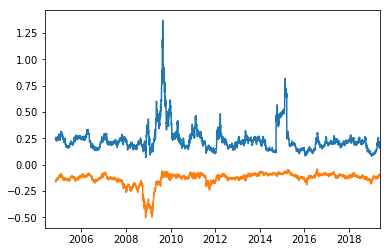

In [140]:
# Average increase and decrease over a give time period
prices = px_close.dropna(subset=[bench])[tickers]
excl_tickers = list(prices.iloc[-1].isna().loc[prices.iloc[-1].isna().values].index)
prices = prices[excl(prices.columns, excl_tickers)]

look_ahead = context['look_ahead']
pos_ret = prices.pct_change(look_ahead).where(prices.pct_change(look_ahead) > 0)
pos_ret.mean(1).plot();
neg_ret = prices.pct_change(look_ahead).where(prices.pct_change(look_ahead) < 0)
neg_ret.mean(1).plot();
print(f'Mean positive: {pos_ret.mean(1).mean()}, Mean negative: {neg_ret.mean(1).mean()}')

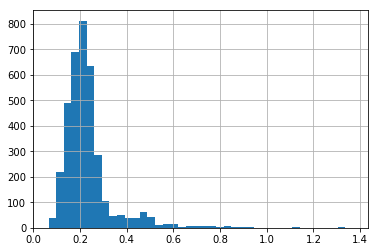

In [135]:

pos_ret.mean(1).hist(bins=40)
# pos_ret.mean(1).plot.kde(secondary_y=True)

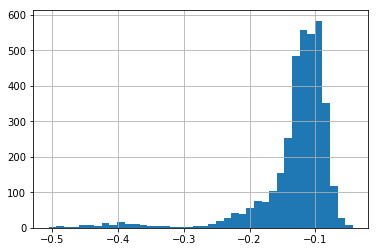

In [136]:
neg_ret.mean(1).hist(bins=40)
# neg_ret.mean(1).plot.kde(secondary_y=True)

In [550]:
# class distribution cuts
np.round(get_return_intervals(prices, 120, tresholds=[0.1, 0.5]), 2)

array([ -inf, -0.23, -0.15,  0.14,  0.22,   inf])

#### Max draws / Max pulls

Max draw: -0.09079279780791061, Max pull: 0.09960461974123547


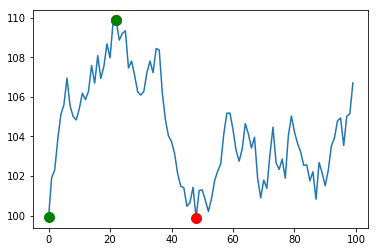

In [543]:
# Test cumulative drawdowns and pulls
from utils.pricing import max_draw_pull

n = 100
r_w = np.random.randn(n).cumsum() + 100
l_dd, h_dd, l_p, h_p = max_draw_pull(r_w)

plt.plot(r_w)
plt.plot([l_dd, h_dd], [r_w[l_dd], r_w[h_dd],], 'o', color='Red', markersize=10)
plt.plot([l_p, h_p], [r_w[l_p], r_w[h_p]], 'o', color='Green', markersize=10)

print(f'Max draw: {r_w[l_dd]/r_w[h_dd]-1}, Max pull: {r_w[h_p]/r_w[l_p]-1}')

#### Date and minute based time analysis

In [ ]:
freq = '1d'

In [ ]:
# s1, s2 = '1810.HK', 'AAPL'
group_pricing = pd.DataFrame()
df1 = get_symbol_pricing(s1, freq, ['close'])
df2 = get_symbol_pricing(s2, freq, ['close'])
group_pricing = pd.DataFrame(df1)
# group_pricing.loc[:, s2] = df2
group_pricing = pd.concat([group_pricing, df2], axis=1)
group_pricing.describe()
# group_pricing

In [ ]:
path = config['pricing_path'].format(freq)
data_dict = json_load(path + json_ext.format(ticker))

tz = data_dict['meta']['exchangeTimezoneName']
df = build_px_struct(data_dict, freq)

adjClose = data_dict['indicators']['adjclose'][0] if 'adjclose' in  data_dict['indicators'] else 0
close = data_dict['indicators']['quote'][0]
data_dict.keys(), data_dict['indicators'].keys()

In [ ]:
df.index.date

In [ ]:
dates = pd.to_datetime(
        data_dict['timestamp'], 
        unit='s', infer_datetime_format=True)
# dates = dates.astype(f'datetime64[ns, {tz}]')
# dates.tz_convert('America/New_York')
# dates = dates.tz_localize('America/New_York')
dates.floor('d' if freq == '1d' else 'min')

In [ ]:
df.tail(5)

In [ ]:
freq = '1d'

In [ ]:
%time px_close = get_mults_pricing(symbols_list[:10], freq);

In [ ]:
# [px_close[x].dropna().tail() for x in px_close.columns]
px_close.describe()
# px_close.tail()

In [ ]:
f'Ticker: {ticker}'

In [ ]:
px = get_symbol_pricing(ticker, freq)
px.close.tail()

#### Old code

In [ ]:
# test distribution of Y variable
tickers = list(mu.sample_sector_tickers(eqty_symbols, profile, sectors, 50).index)
context['grid_search'] = False
context['tickers'] = tickers
context['train_model'] = True

df_large = create_ds(context)

df = df_large.copy()
df.dropna(subset=[y_col], inplace=True)
df[y_col] = discret_rets(df[y_col], cut_range, fwd_ret_labels)
df.dropna(subset=[y_col], inplace=True) # no nas in y_col
df[y_col] = df[y_col].astype(str) # class as string
sample_wgts(df[y_col])

pred_X, X_traxin, X_test, y_train, y_test = pre_process_ds(df_large, context)
pd.value_counts(discret_rets(df_large.fwdReturn, cut_range, fwd_ret_labels)).sum()
pd.value_counts(pd.concat([y_train, y_test], axis=0)).sum()

In [ ]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

In [ ]:
fwd_ss_ret = lambda x, df, arr: df.loc[[y for y in arr[x-1] if y in df.index.tolist()]].mean()

In [ ]:
# seasonality analysis
ss_df = closepx.pct_change().resample('M').sum().to_frame()
ss_df['year'], ss_df['month'] = ss_df.index.year, ss_df.index.month
ss_df = ss_df.pivot_table(index='year', columns='month').mean()
ss_pos = [(x, (x+1) if not (x+1) // 12 else 0, 
     x+2 if not (x+2) // 12 else x - 10) for x in range(12)]

# [fwd_ss_ret(x+1, ss_df['close'], ss_pos) for x in range(12)] # test

In [ ]:
# apply seasonality, mean return of curr month plus next two
secpx['month'] = secpx.index.month
secpx['fwdSSRet'] = secpx.loc[:].month.apply(
    fwd_ss_ret, args=(ss_df['close'], ss_pos,))

In [ ]:
secpx.columns # all columns

In [ ]:
# normalized columns for ML training, still has outliers
ml_ds_cols = secpx.describe().loc['50%'][secpx.describe().loc['50%'] < 5].index.tolist()
ml_ds_cols

In [ ]:
# prepare ML dataset
ml_ds = secpx[ml_ds_cols].copy()

class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

for c in class_cols: ml_ds[c] = pd.cut(secpx[c], cut_range, labels=fwd_ret_labels)
ml_ds.info()

In [ ]:
# drop the predicting class with most nas
ml_ds.dropna(inplace=True)
ml_ds.info()

In [ ]:
ml_ds.hist(figsize=(15,15));

In [ ]:
ml_ds.to_csv(csv_ext.format('co_price_mom_ds'), index=False)